In [1]:
# Sharpe Optimization Function 
import numpy as np
from scipy import optimize
import pandas as pd

# **Sharpe Ratio = (rx - Rf)/(sigma)** 
# where,
# **rx** = mean return on investment x
# **Rf** = risk free rate
# **sigma** = standard deviation on x
# Model for Sharpe ratio wrt. Portfolio optimisation: (iff. 0 <= Wi <= 1)

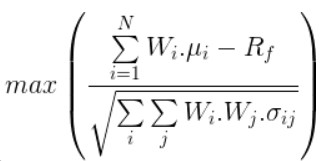

In [2]:
# Maximise Sharpe ratio, ensuring 100% investment 1< allocation

def SharpeOpt(rx, covReturns, Rf, noAssets):

  # Replicating {=MMULT{=MMULT}}, and maximising sharpe
  def minSharpe(x, rx, covReturns, Rf, noAssets):

    # This is inplace to catch common error of 
    denominator = np.sqrt(np.matmul(np.matmul(x.T, covReturns), x))
    
    numerator = np.matmul(np.array(rx), x.T) - Rf
    maxSR = -(numerator / denominator)
    return maxSR

  # Ensure portfolio allocation fully allocated (100%)
  def fullyInvested(x):
    weights = np.ones(x.shape)
    b=1
    constraint = np.matmul(weights, x.T) - b
    return constraint

  # Define bounds, eg. 0% < 100% allocations. I don't understand xinit, cons 
  # and bounds I but its the only solution I could find online.
  xinit = np.repeat(0.33, noAssets)
  constraints = ({'type' : 'eq', 'fun' : fullyInvested})
  lower = 0
  upper = 1
  bnds = tuple([(lower, upper) for x in xinit])

  # Actually optimise (minimise minSharpe gives maxSharpe, slightly backwards 
  # but it works, using sequential least squares)
  optimisation = optimize.minimize(minSharpe, x0=xinit, args=(rx, covReturns, Rf, noAssets), method='SLSQP', bounds=bnds, constraints=constraints, tol=10**-3)

  return optimisation

In [3]:
# Function to compute stock returns 
def StockReturnsCalc(stockPrices, rows, cols):

  # Empty matrix then iterate over every cell in csv (cols = asset, rows = prices)
  StockReturns = np.zeros([rows-1, cols])
  for j in range(cols):
    for i in range(rows-1):
      StockReturns[i, j] = ((stockPrices[i+1, j] - stockPrices[i, j]) / stockPrices[i, j]) * 100

  return StockReturns

In [ ]:
# Variance covariance and mean calculator for csv of our stock selections
# This code block is our input 

securitiesFile = '/content/Target_Vol.csv'        

# csv shape  
rows = 1050
columns = 8

df = pd.read_csv(securitiesFile, nrows = rows)
assets = df.columns[1:columns+1].tolist()

# If we wish to wrangle any more data from price close, set an index to make it easier
df.set_index(['Date']) 

priceData = df.iloc[0:, 1:]

# Conver data from csv into array, now on data is referred to as assets because (hopefully)
# code is compatible with stocks, bonds, etfs and crypto 

assetPrices = np.asarray(priceData)
[Rows, Cols] = assetPrices.shape
assetReturns = StockReturnsCalc(stockPrices=assetPrices, rows=Rows, cols=Cols)

np.set_printoptions(precision=3, suppress=True)

# Finally calculate
meanReturns = np.mean(assetReturns, axis=0)
covariance_matrix = np.cov(assetReturns, rowvar=False)

print('Portfolio assets are: \n{}'.format(assets))
print('\nMean returns for assets are respectively: \n{}'.format(meanReturns))
print('\nCovariance matrix is: \n {}'.format(covariance_matrix))


# Current risk free rate on 10y US treasury = 1.59%, this will need to be changed closer to the time of portfolio construction.
# To annualise daily Rf:

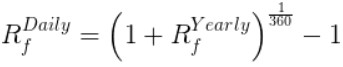

In [ ]:
# Optimisation params, 
allAssets = columns
Rf = 1.59
annualRf = 1.59/100

dailyRf = (np.power((1 + annualRf), (1 / 360)) -1) * 100
print('Apporximate Daily Rf: {}%'.format(np.round(dailyRf, decimals=4)))

# Initialise optimisation
optimalWeights = []
expPfRtn = []
minRisk = []
sharpeMax = 0


In [ ]:
# Optimum weights
result = SharpeOpt(meanReturns, covariance_matrix, dailyRf, allAssets)
optimalWeights.append(result.x)

# Risks, expected return and max Sharpe ratio of optimised portfolio
weightsArray = np.array(optimalWeights)
risk = np.matmul((np.matmul(weightsArray, covariance_matrix)), np.transpose(weightsArray))
expReturn = np.matmul(np.array(meanReturns), weightsArray.T)
annualRisk = np.sqrt(risk*252)
annualReturn = 252*np.array(expReturn)
maxSharpeRatio = (annualReturn - Rf) / annualRisk

np.set_printoptions(precision=3, suppress=True)
print('Max Sharpe Ratio: ', np.around(maxSharpeRatio[0, 0], decimals=3))
print('Annualised Risk (%): ', np.around(annualRisk[0, 0], decimals=4), '%')
print('Expected Annual Return: ', np.around(annualReturn[0], decimals=4), '%')
print('Optimal Weights:\n', assets, '\n', weightsArray[0])

df_weights = pd.DataFrame(optimalWeights)
df_weights